In [1]:
# 線形回帰(Linear Regression)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import tqdm

import lightgbm as lgb
from lightgbm import LGBMRegressor
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import KFold
from statsmodels.tsa.ar_model import AutoReg
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Lasso
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler

In [2]:
df = pd.read_excel("../data/raw/kadai.xlsx")
df.head()

,process_end_time,final_mes_time,OV,X1,X2,X3,X4,X5,X6,X7,...,X74,X75,X76,X77,X78,X79,X80,X81,X82,X83
0,2016-08-14 23:07:00,2016-09-24 04:22:00,111.2886,22.98,1.37,797.20,0.67,0.15,0.08,67.15,...,0.1,0.04,6.4,0.58,0.0,4.1,0.0,0.01,0.16,0.04
1,2016-08-14 23:07:00,2016-09-24 10:12:00,201.5617,22.45,9.40,803.80,0.68,0.15,0.08,56.11,...,0.1,0.04,6.4,0.58,0.0,4.1,0.0,0.01,0.16,0.04
2,2016-08-14 23:07:00,2016-09-24 14:11:00,111.9410,22.03,1.14,594.52,0.64,0.14,0.08,51.57,...,0.1,0.04,6.4,0.58,0.0,4.1,0.0,0.01,0.16,0.04
3,2016-08-14 23:07:00,2016-09-24 15:30:00,182.3914,22.98,1.37,797.20,0.67,0.15,0.08,67.15,...,0.1,0.04,6.4,0.58,0.0,4.1,0.0,0.01,0.16,0.04
4,2016-08-14 23:07:00,2016-09-24 18:31:00,196.2703,22.98,1.37,797.20,0.67,0.15,0.08,67.15,...,0.1,0.04,6.4,0.58,0.0,4.1,0.0,0.01,0.16,0.04


In [3]:
df_use = df.copy()

In [4]:
df_use.shape

(2276, 86)

In [5]:
#"process_end_time"と"final_mes_time"を時系列オブジェクトに変換する
df_use["process_end_time"] = pd.to_datetime(df_use["process_end_time"])
df_use["final_mes_time"] = pd.to_datetime(df_use["final_mes_time"])

#予測結果を入れる空のリストを作成
yHat = []

In [10]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform

# 使用する特徴量カラム名をリストで正しく指定
feature_cols = [f"X{i}" for i in range(1, 84)]

scoring = "neg_root_mean_squared_error"

# 置き換え用：連続/離散分布で探索（listでもOKだが分布の方が強い）
param_dist = {
    "model_LGBM__num_leaves": randint(8, 64),          # [8,63]
    "model_LGBM__max_depth": [-1, 3, 4, 5, 6, 7, 8],
    "model_LGBM__min_child_samples": randint(5, 41),   # [5,40]
    "model_LGBM__learning_rate": uniform(0.01, 0.19),  # [0.01,0.20)
    "model_LGBM__n_estimators": randint(100, 801),     # [100,800]
    "model_LGBM__verbose": [-1],
}


# 1レコードずつtestにしてループ
for i in tqdm.tqdm(np.arange(1776, 2276)):
  #最後の500レコードをテストデータとする
  learn = df_use[0:i]
  test = df_use[i:i+1]
  #インデックスをリセットする
  learn = learn.reset_index(drop=True)
  test = test.reset_index(drop=True)
  #テストデータの最初の1レコードの"process_end_time"より前のlearnデータを取り出す
  learn = learn[learn["final_mes_time"] < test['process_end_time'][0]]
  #説明変数と目的変数に分離
  #学習データ
  X_l = learn.drop(['process_end_time', 'final_mes_time', 'OV'], axis=1)
  Y_l = learn.OV
  #テストデータ
  X_t = test.drop(['process_end_time', 'final_mes_time', 'OV'], axis=1)
  Y_t = test.OV

  pipeline = Pipeline([
    #("selector", SelectFromModel(Lasso())),
    ("model_LGBM", LGBMRegressor(
        objective="regression",
        metric="rmse",
        verbose=-1,
        random_state=42
    ))
  ])
  rscv = RandomizedSearchCV(
      estimator=pipeline,
      param_distributions=param_dist,
      n_iter=25,           # ←ここが探索回数（まず25〜50で）
      scoring=scoring,
      cv=5,
      n_jobs=-1,
      verbose=0,           # ログ消す
      random_state=42
  )

  rscv.fit(X_l, Y_l)
  pred = rscv.predict(X_t)
  yHat.append(pred[0])  # 予測値を格納（1レコードなので[0]）

# 予測値リストと正解データの整合性を厳密に合わせる
yh = np.array(yHat)
Y_t = df_use["OV"][1776:2276].reset_index(drop=True)

# 長さを確認し、短い方に合わせて切る（安全対策）
min_len = min(len(Y_t), len(yh))
Y_t = Y_t[:min_len]
yh = yh[:min_len]

# 予測結果の表示
plt.plot(Y_t, label="Actual", color="blue")
plt.plot(yh, linestyle='-', label="Predicted", color="red")
plt.legend()
plt.show()

# RMSEの表示
print("RMSE:")
print(np.sqrt(mean_squared_error(Y_t, yh)))

 15%|█▌        | 75/500 [1:50:11<10:24:25, 88.15s/it]


KeyboardInterrupt: 

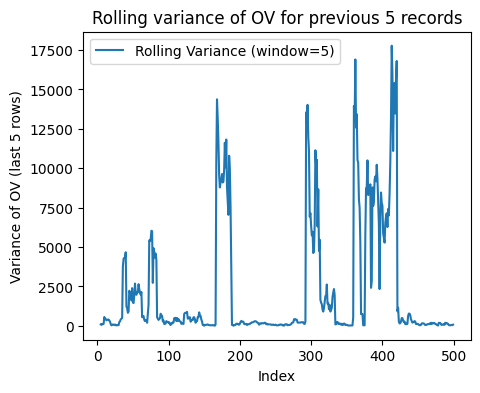

In [ ]:
# レコードごとに、直前5行の「OV」の分散を計算し、その推移をプロットする

ov_var_list = []
for i in range(len(df_use[1776:2276])):
    if i < 5:
        # 5行目未満はnanなどで埋める
        ov_var_list.append(np.nan)
    else:
        # 直前5行のOVの分散
        ov_var_list.append(df_use[1776:2276]["OV"].iloc[i-5:i].var())

plt.figure(figsize=(5,4))
plt.plot(ov_var_list, label='Rolling Variance (window=5)')
plt.xlabel("Index")
plt.ylabel("Variance of OV (last 5 rows)")
plt.title("Rolling variance of OV for previous 5 records")
plt.legend()
plt.show()


OVが100以下と100超での全数値変数（平均値・中央値）の差：


,mean_OV<=100,mean_OV>100,diff_mean,median_OV<=100,median_OV>100,diff_median,abs_diff_mean
X22,744.248394,1055.342772,311.094378,350.00,490.00,140.00,311.094378
X7,111.675289,192.517981,80.842692,73.15,123.64,50.49,80.842692
X45,522.111467,598.851416,76.739949,538.88,591.95,53.07,76.739949
X3,622.830493,673.805253,50.974761,655.34,726.27,70.93,50.974761
X49,68.722099,90.498435,21.776337,34.98,46.40,11.42,21.776337
...,...,...,...,...,...,...,...
X5,0.141777,0.143718,0.001941,0.14,0.15,0.01,0.001941
X4,0.720193,0.718338,-0.001854,0.63,0.64,0.01,0.001854
X63,0.605000,0.603227,-0.001773,0.58,0.58,0.00,0.001773
X47,0.138555,0.138361,-0.000194,0.14,0.13,-0.01,0.000194



平均値の差が（絶対値で）最大の変数: X22
mean_OV<=100       744.248394
mean_OV>100       1055.342772
diff_mean          311.094378
median_OV<=100     350.000000
median_OV>100      490.000000
diff_median        140.000000
abs_diff_mean      311.094378
Name: X22, dtype: float64


/Users/yutotakagi/Develop/ass-production-management2/.venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 65289 (\N{FULLWIDTH RIGHT PARENTHESIS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


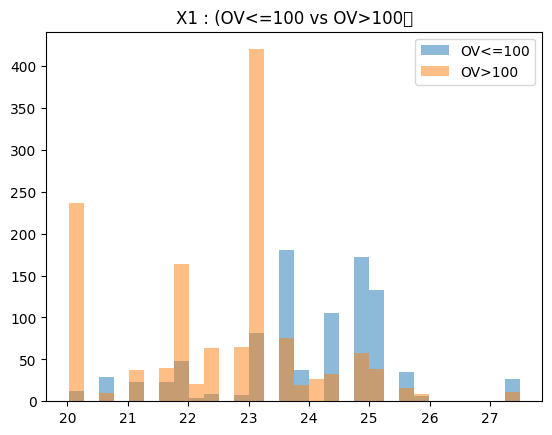

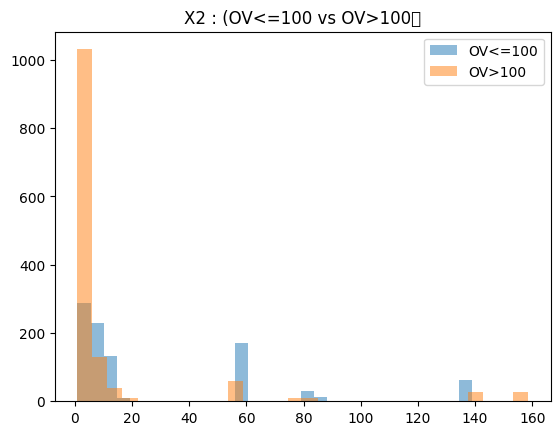

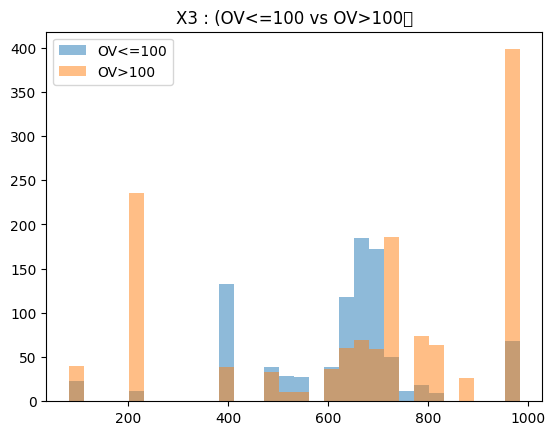

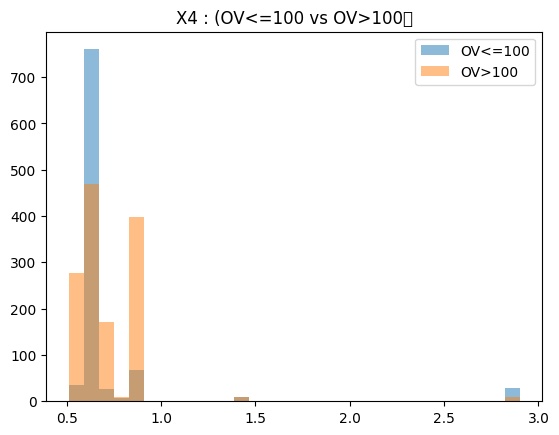

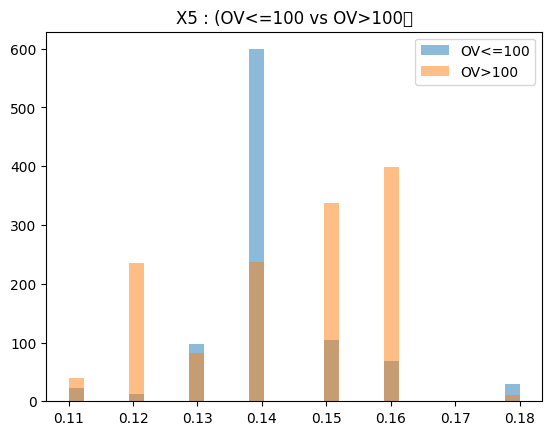

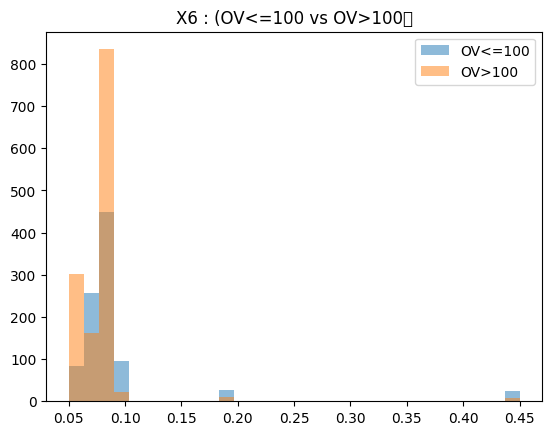

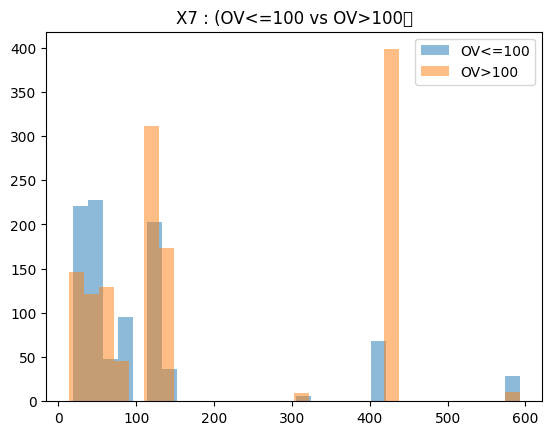

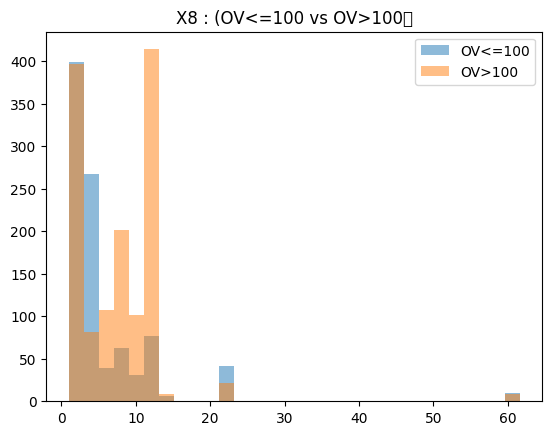

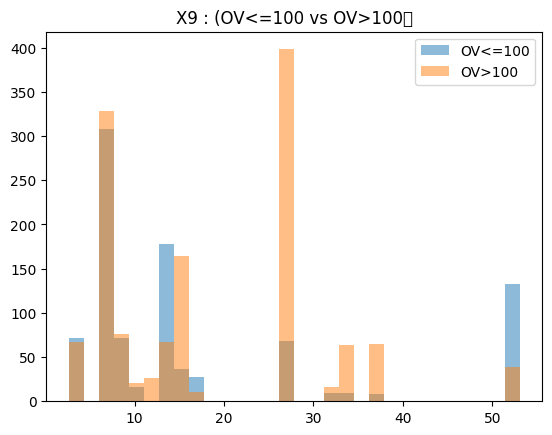

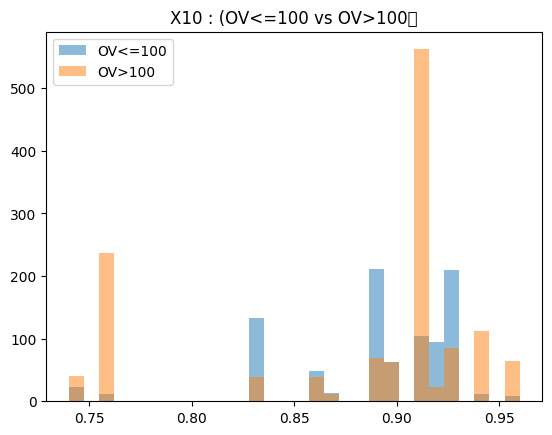

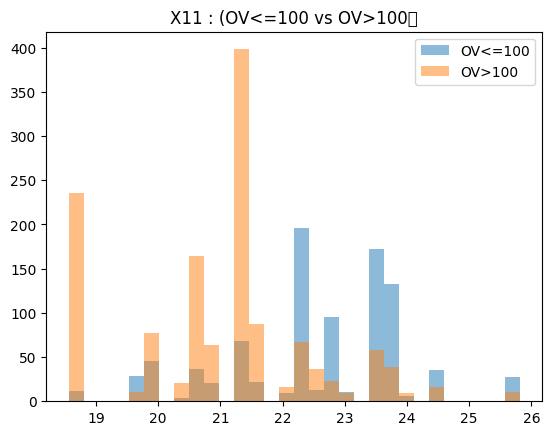

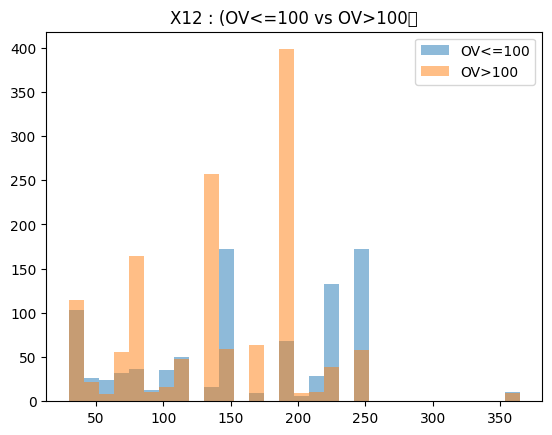

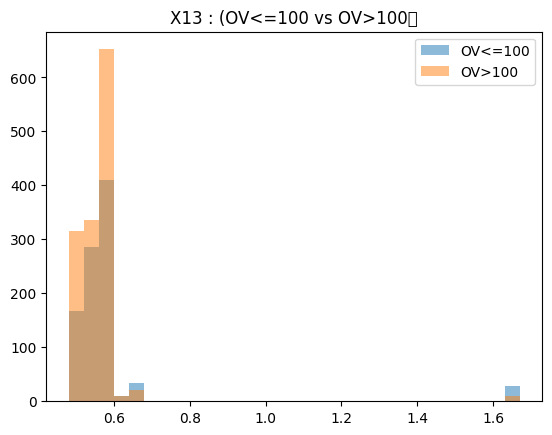

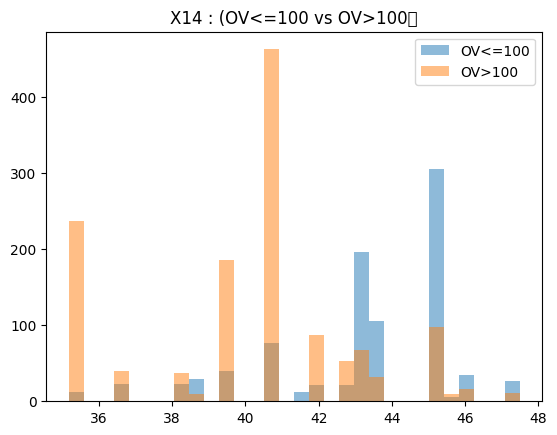

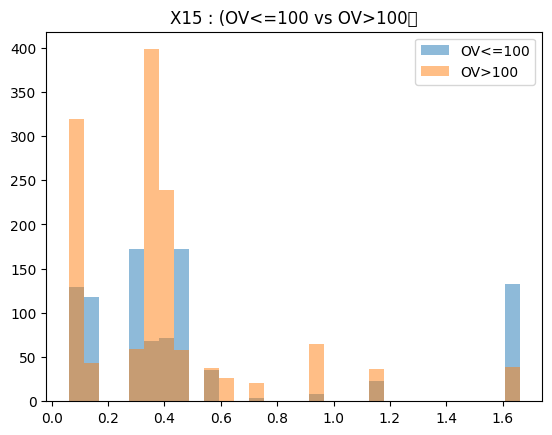

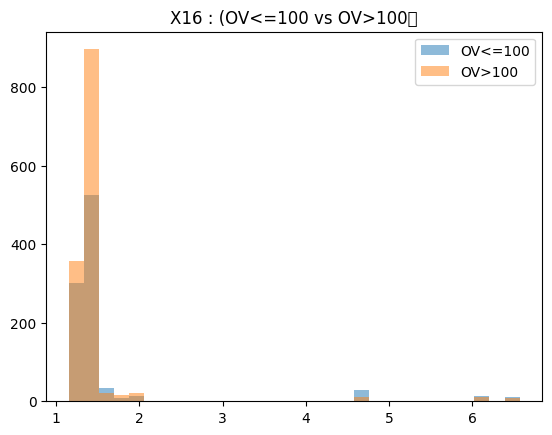

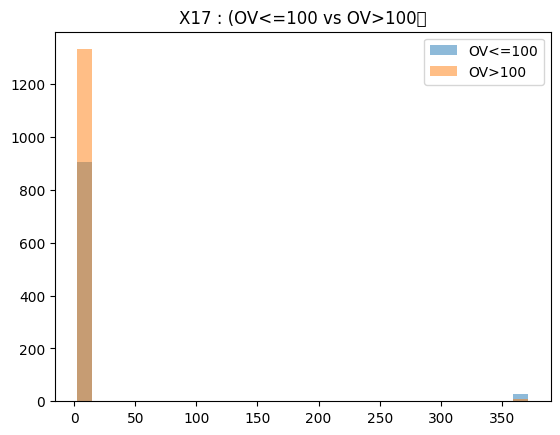

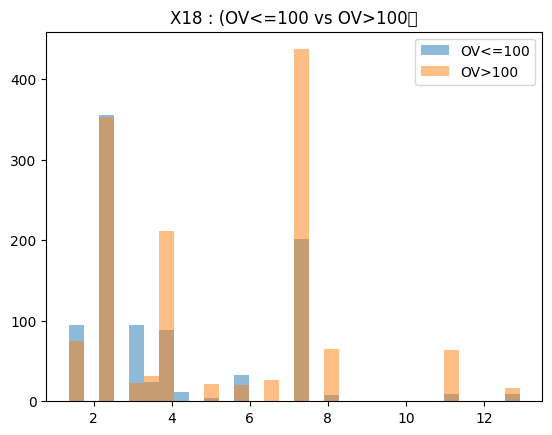

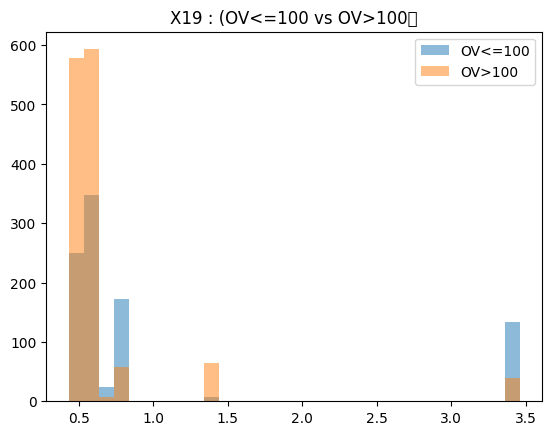

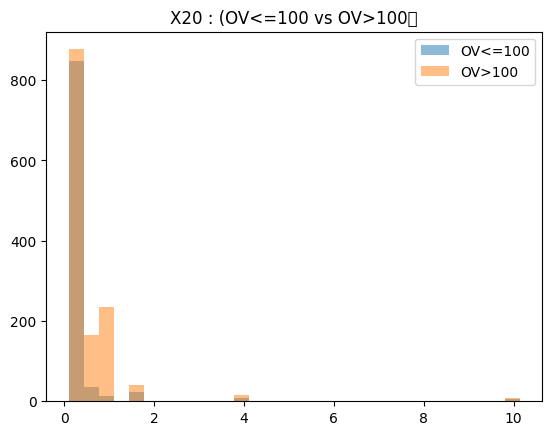

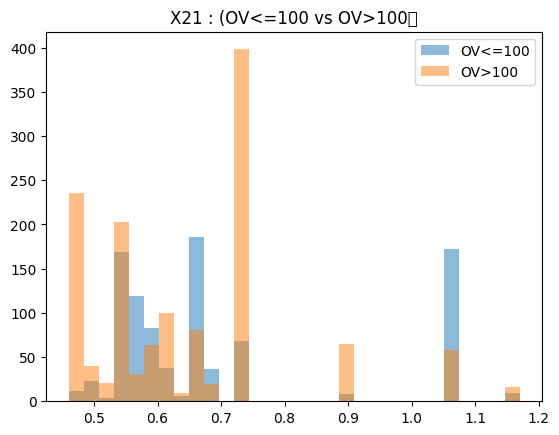

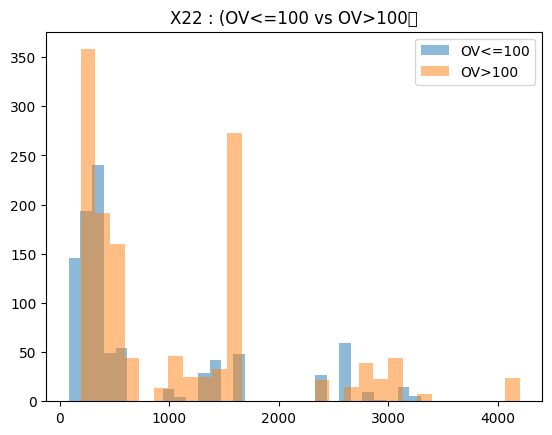

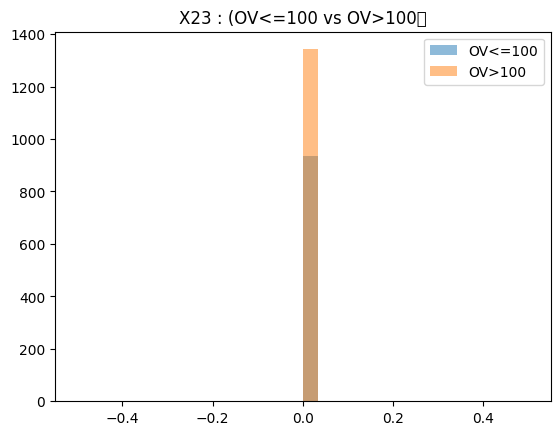

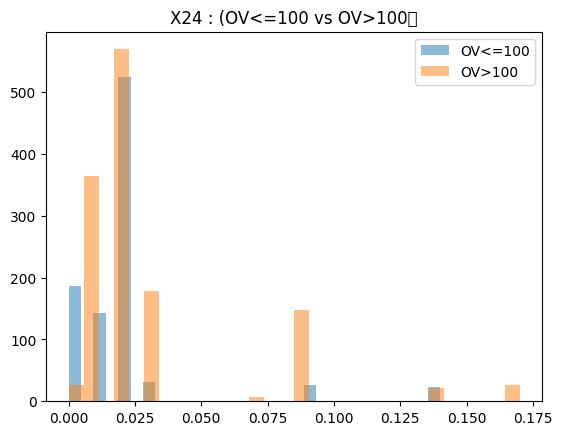

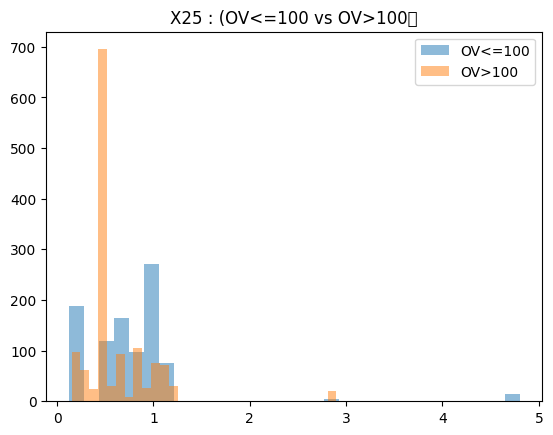

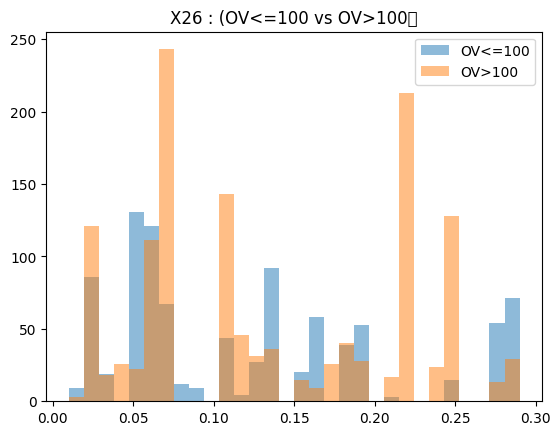

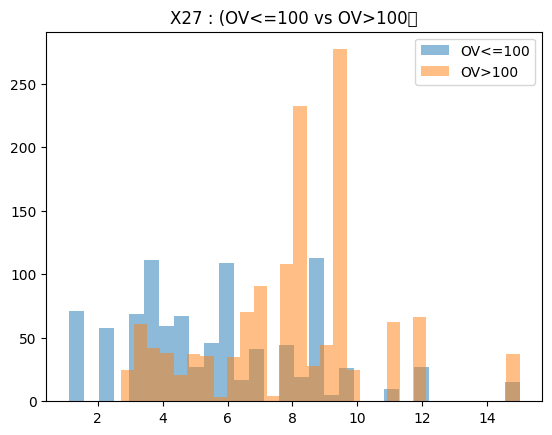

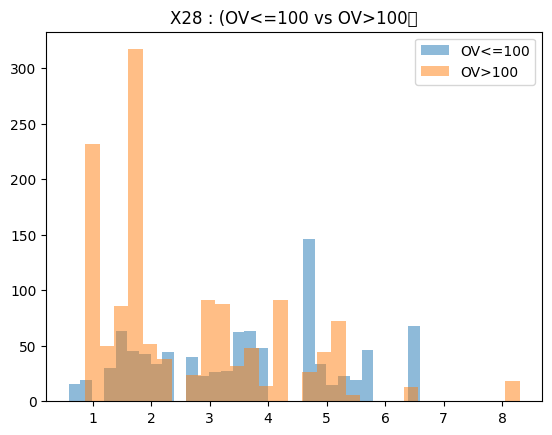

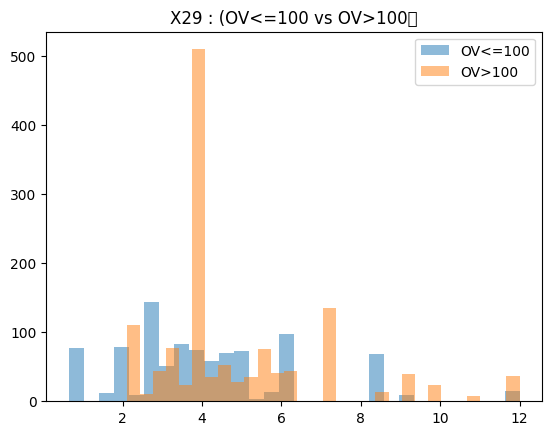

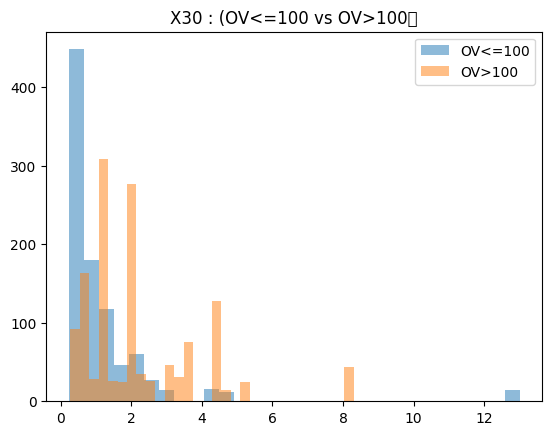

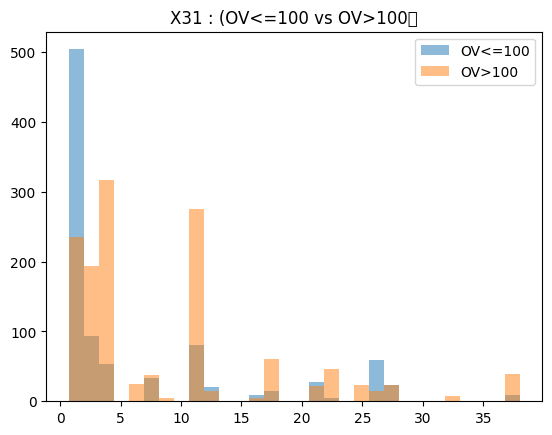

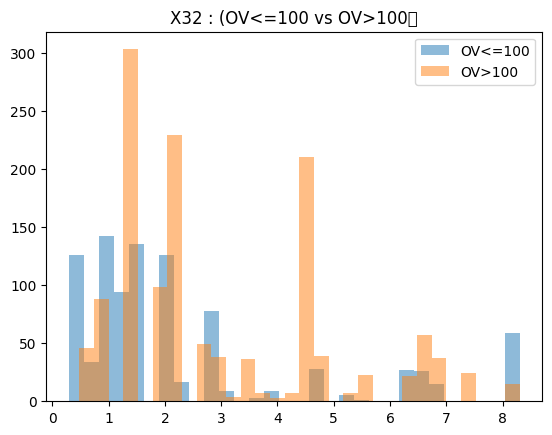

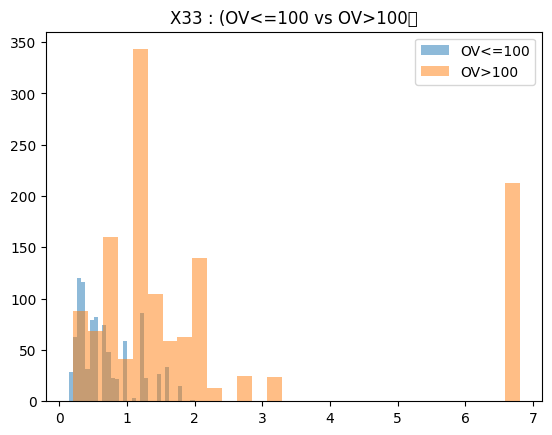

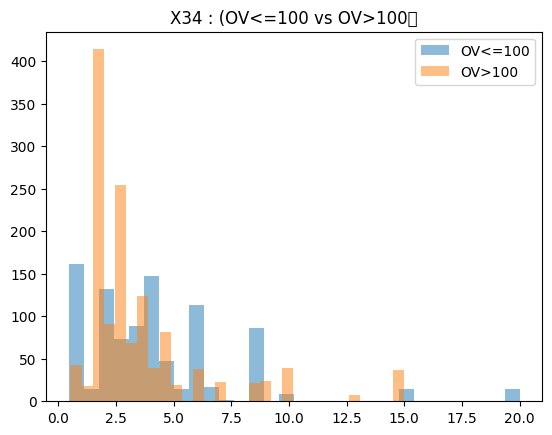

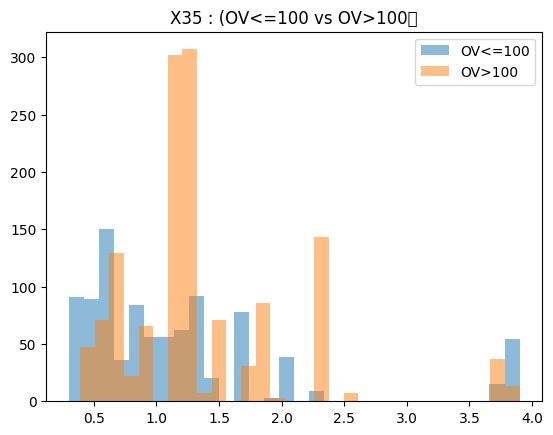

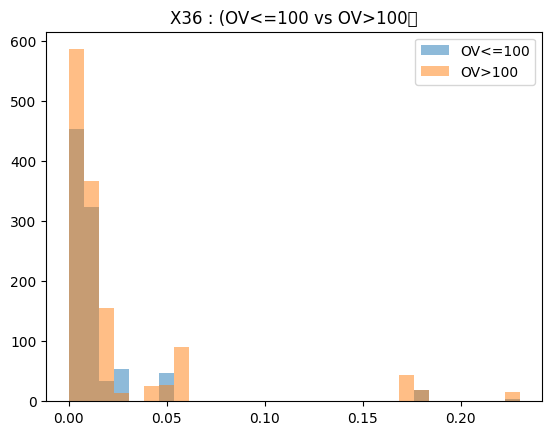

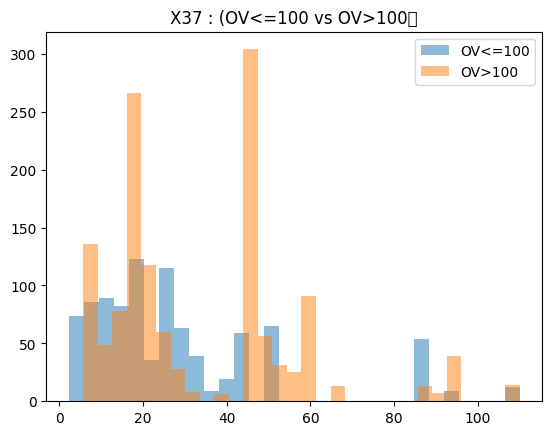

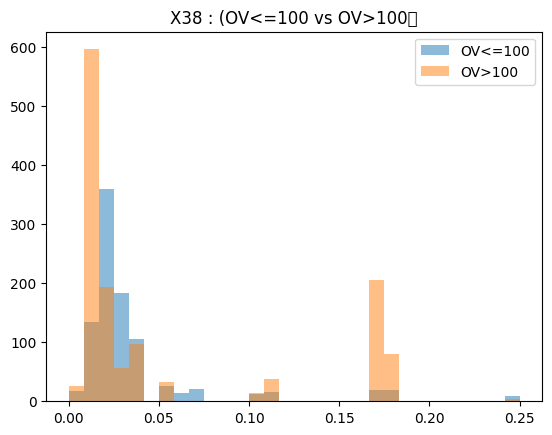

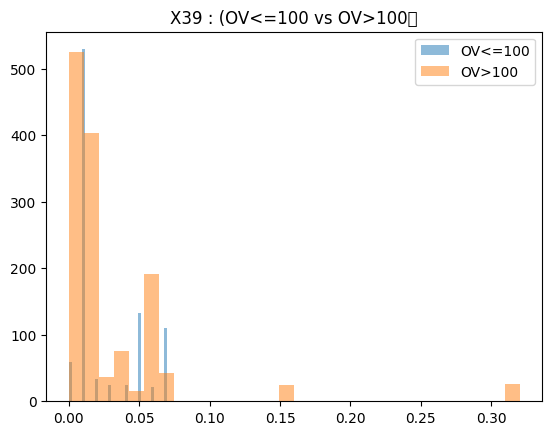

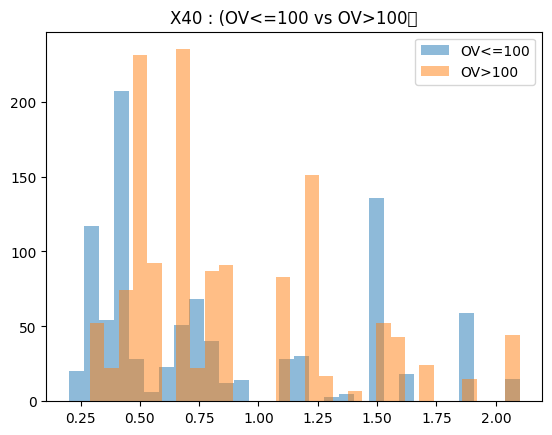

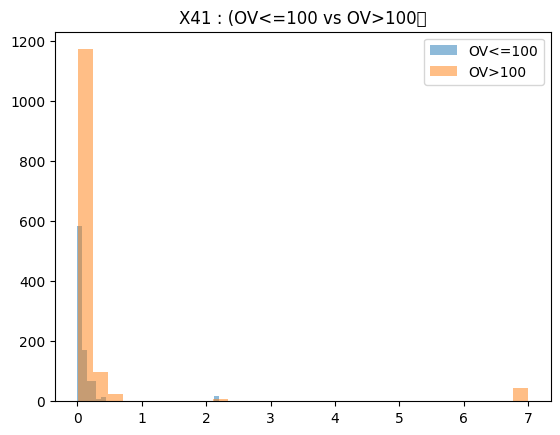

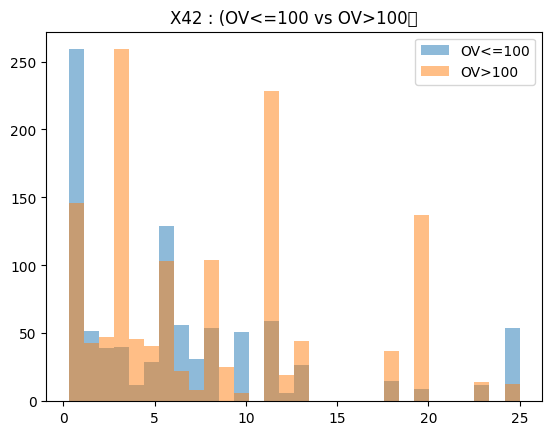

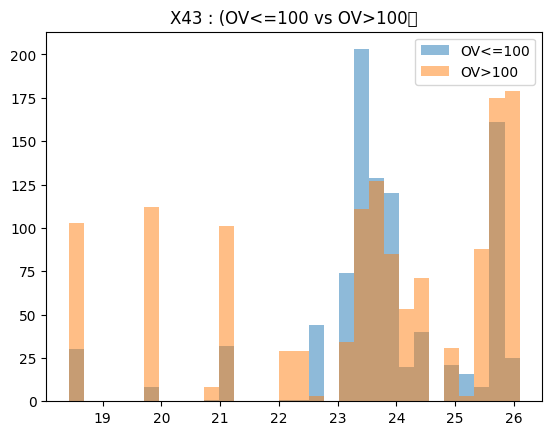

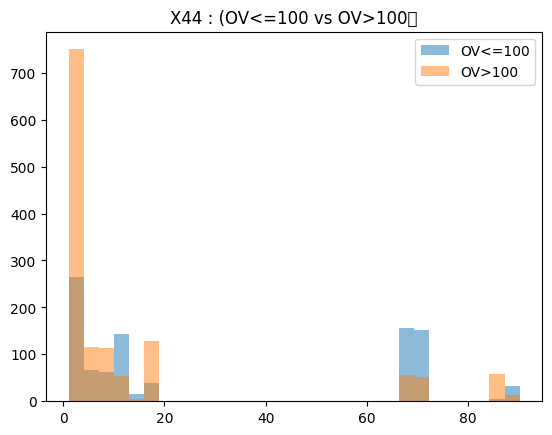

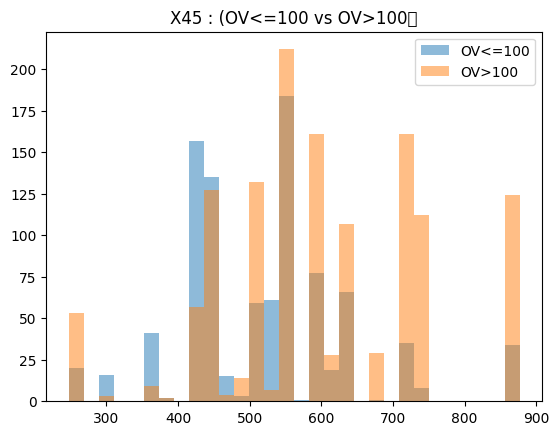

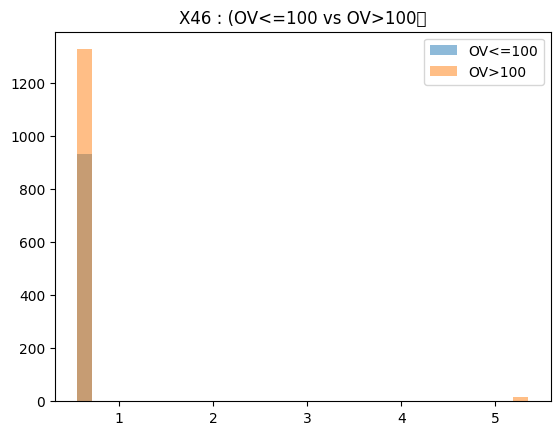

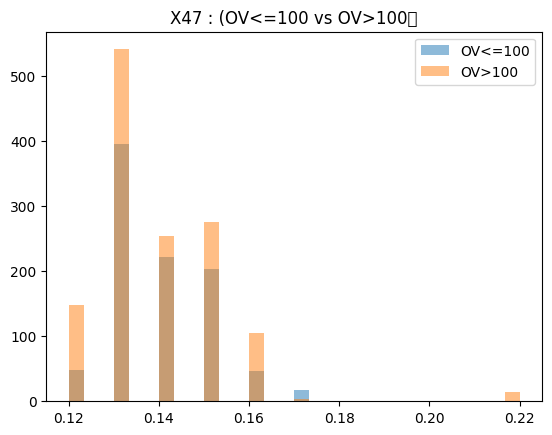

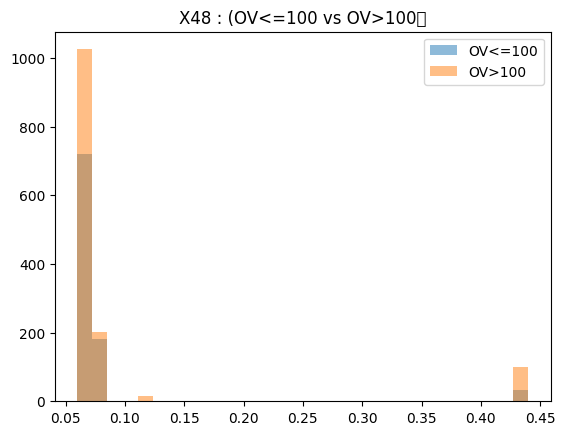

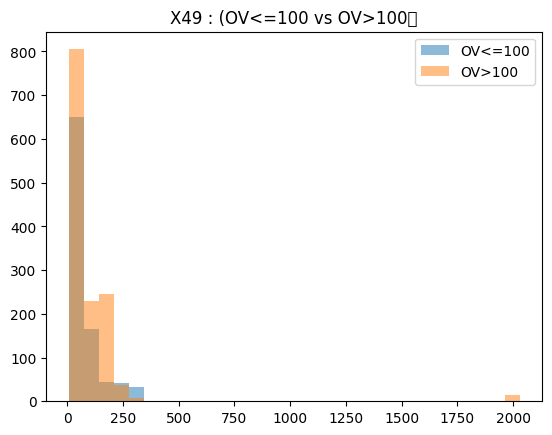

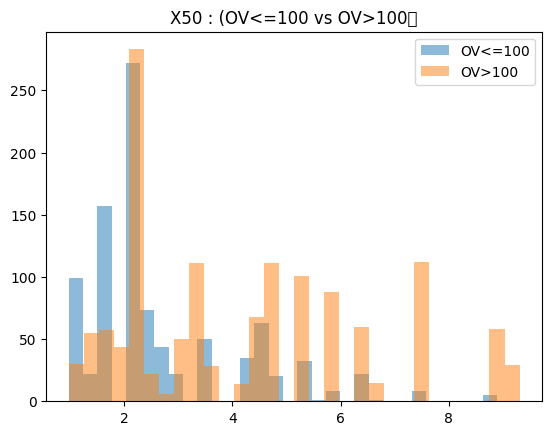

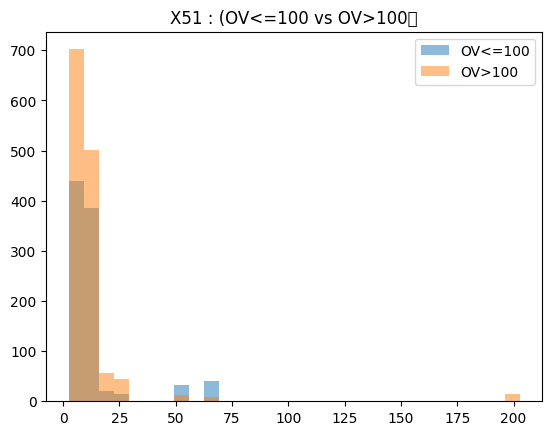

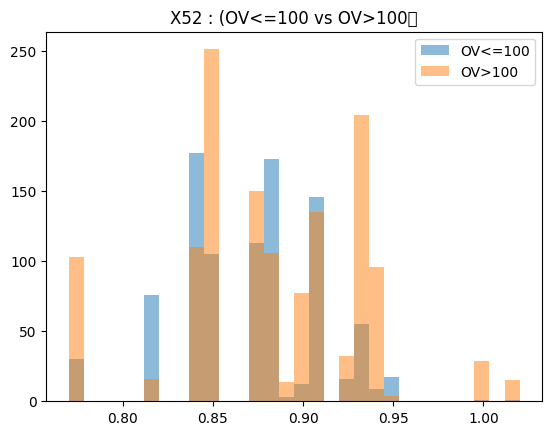

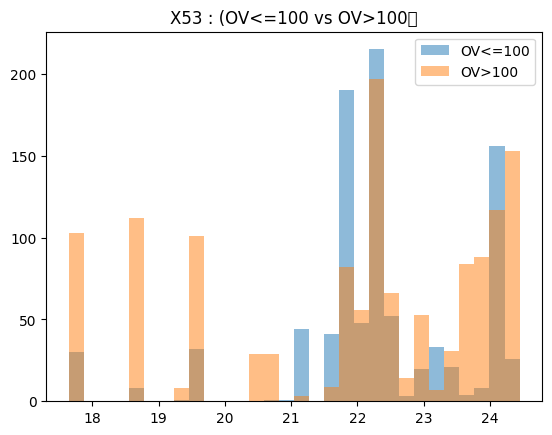

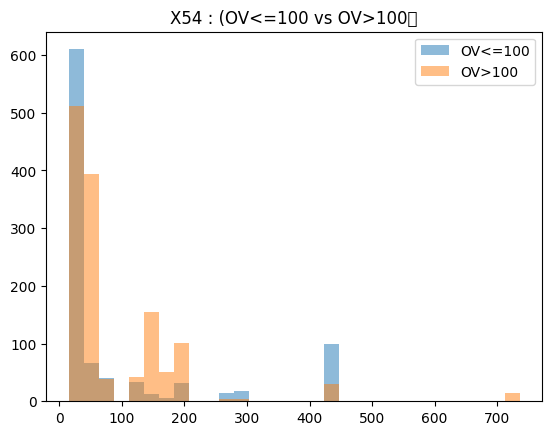

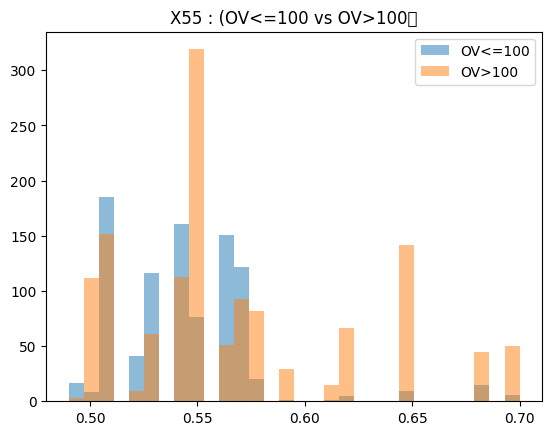

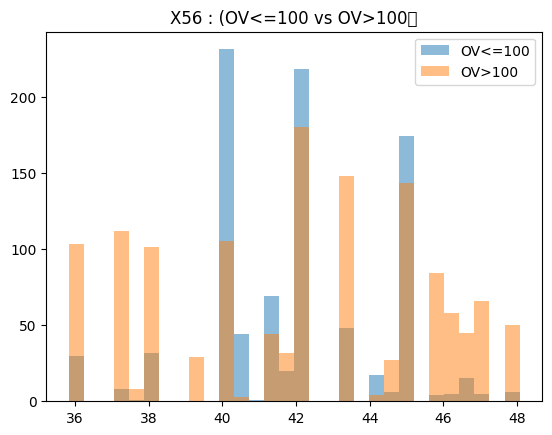

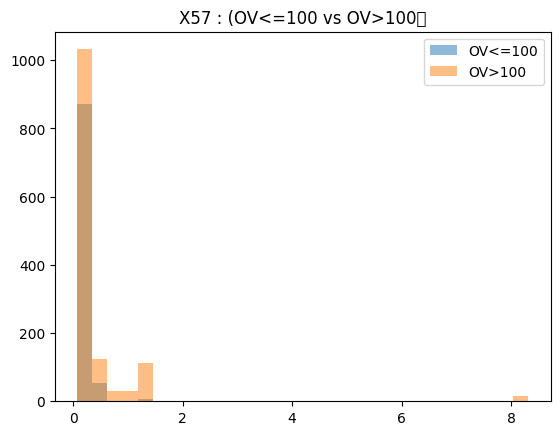

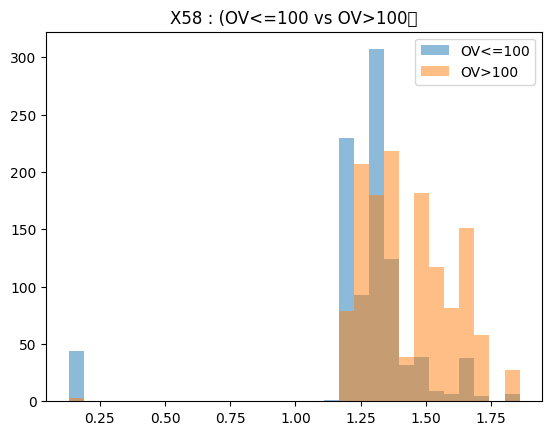

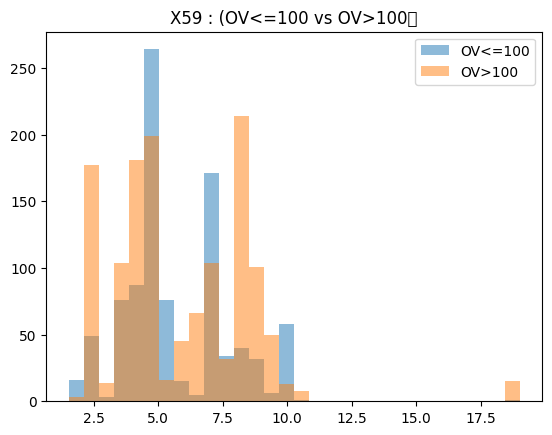

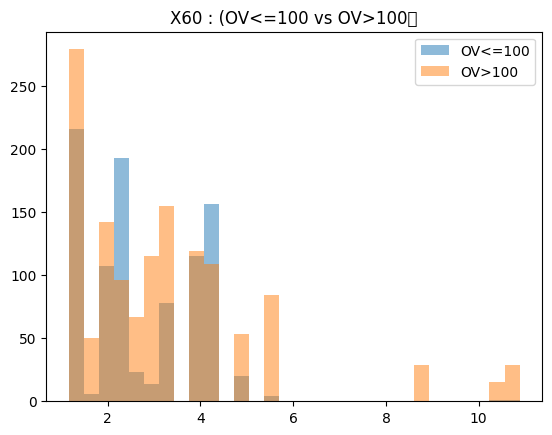

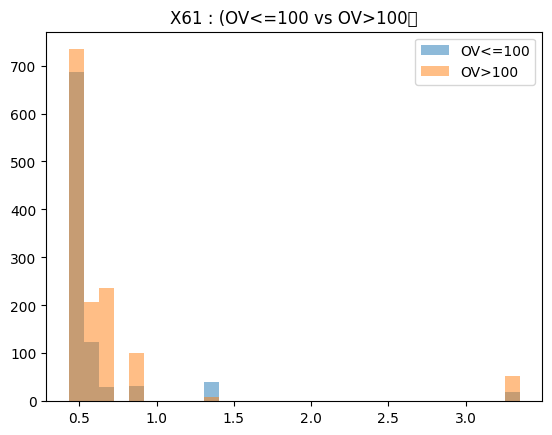

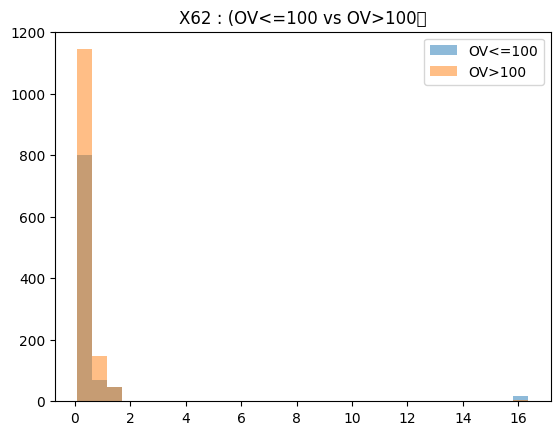

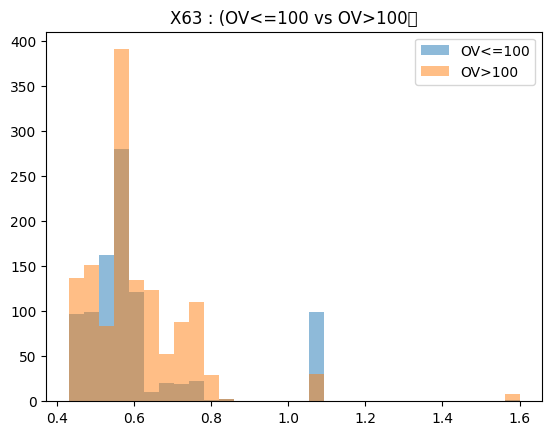

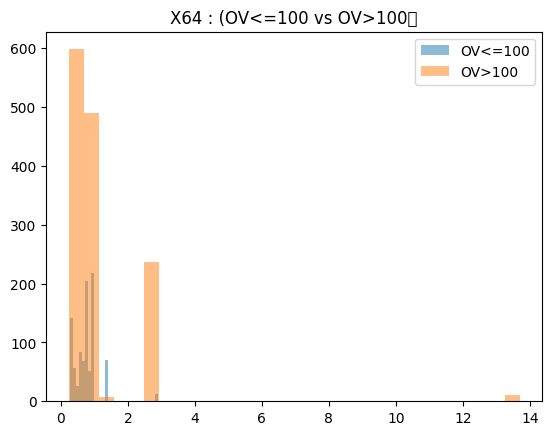

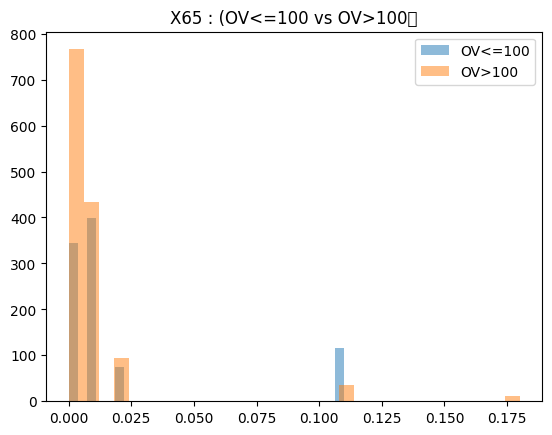

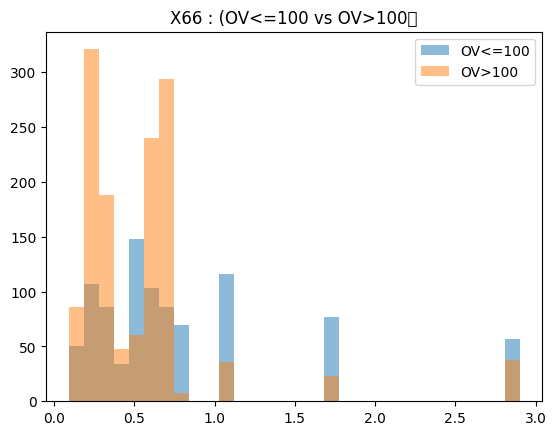

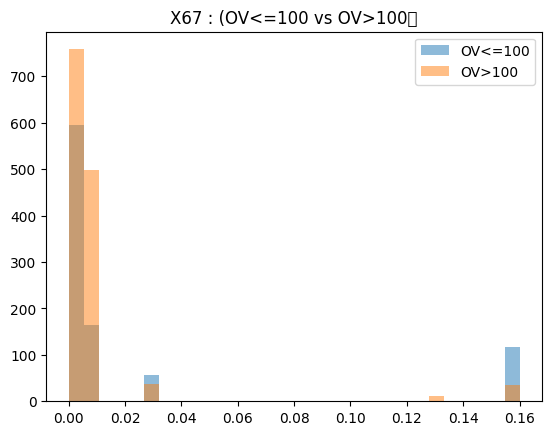

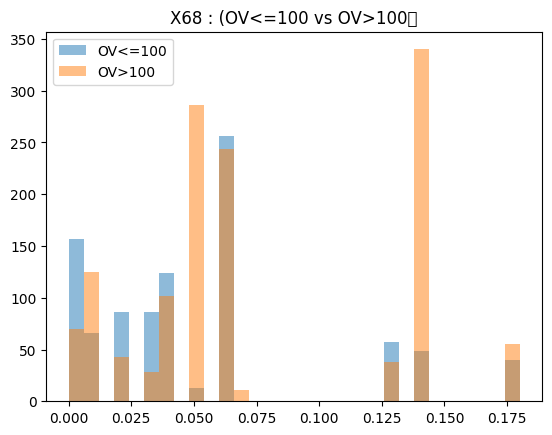

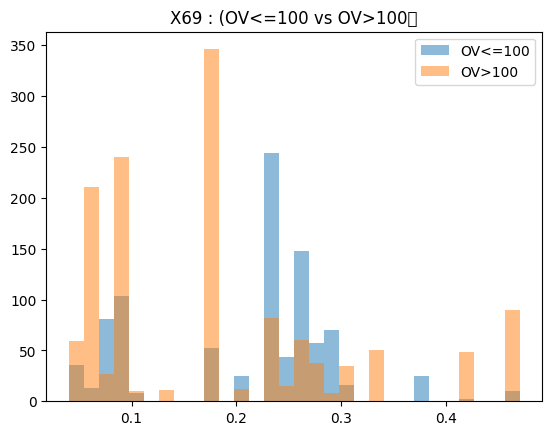

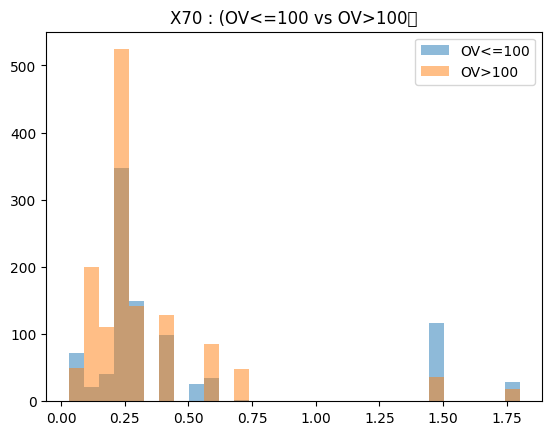

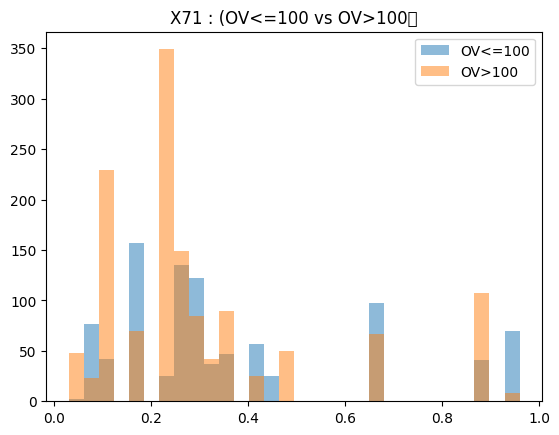

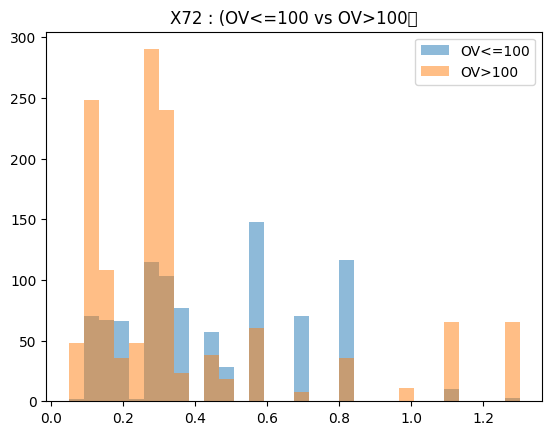

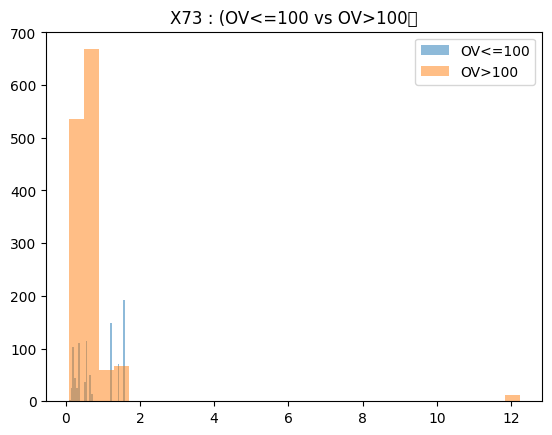

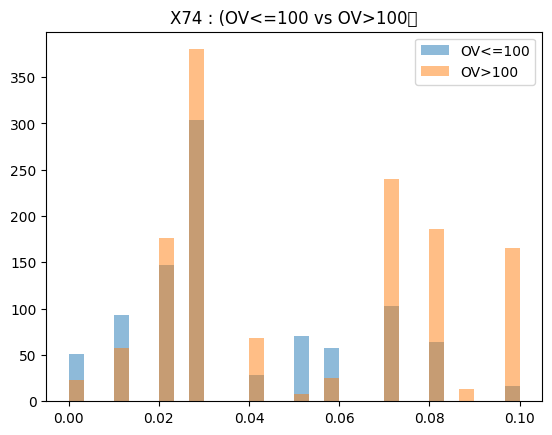

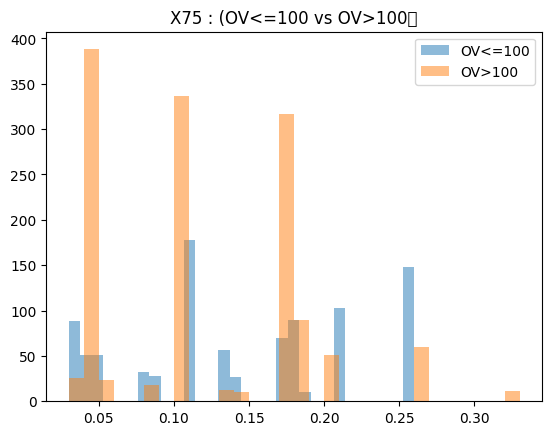

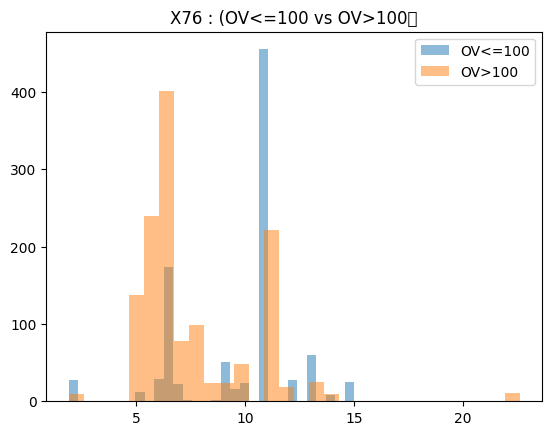

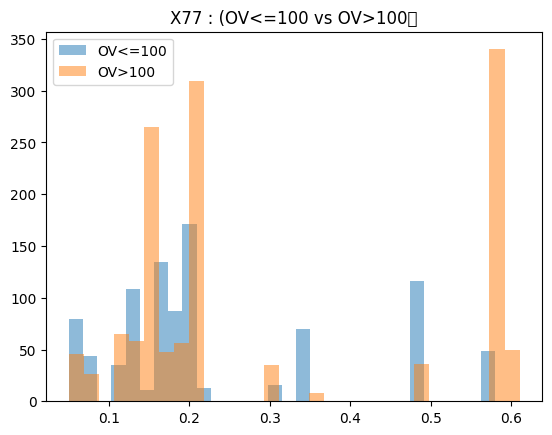

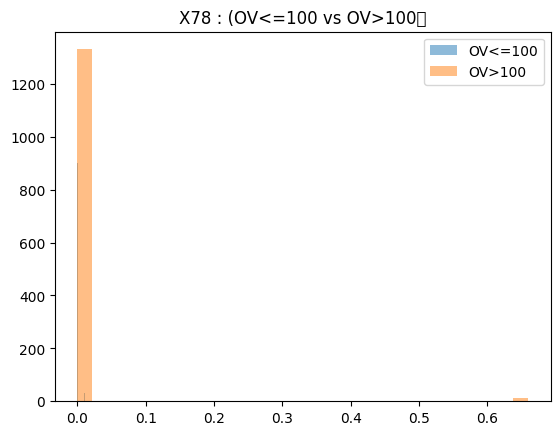

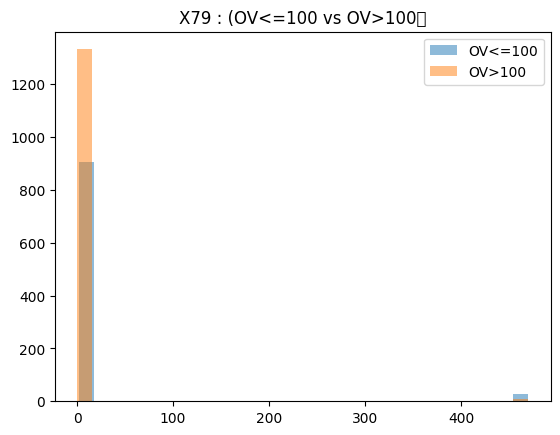

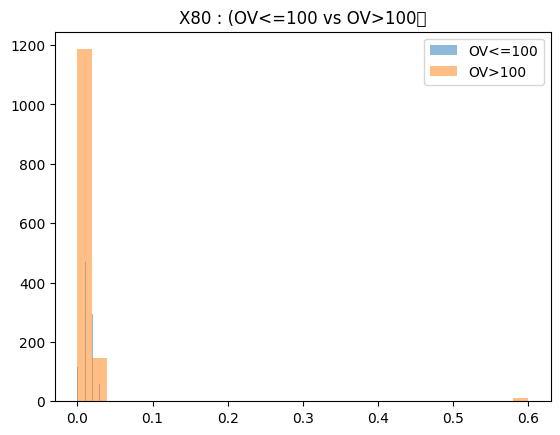

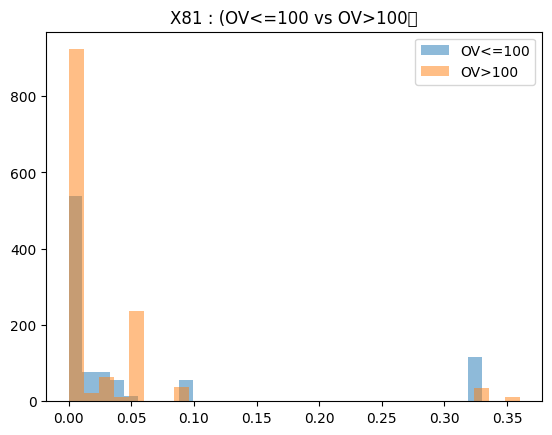

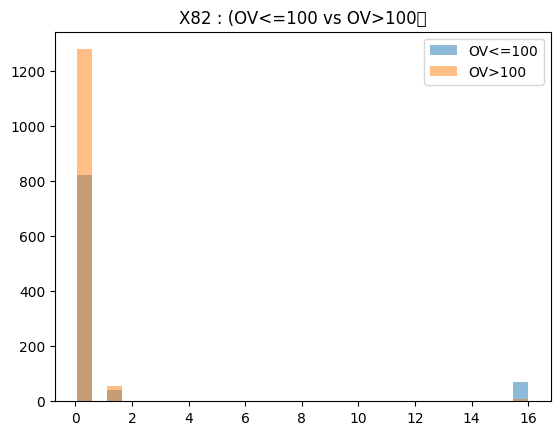

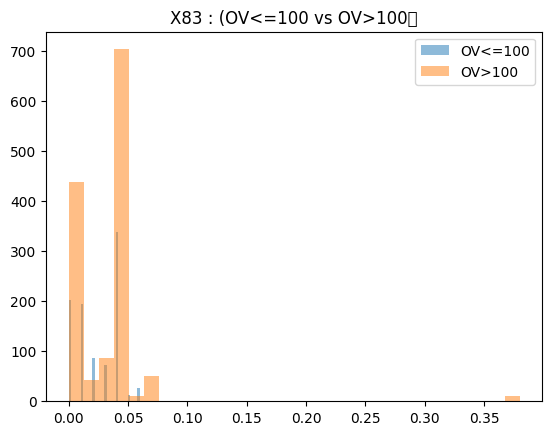

In [ ]:
# OVが100以下と100超で全数値変数で平均・中央値を比較し全カラム分表示。さらに平均差が最大の変数をリストアップ

# OVが100以下のデータ
df_le_100 = df_use[df_use["OV"] <= 100]
# OVが100より大きいデータ
df_gt_100 = df_use[df_use["OV"] > 100]

# 比較対象の数値説明変数一覧（OV, process_end_time, final_mes_time を除く）
exclude_cols = ["OV", "process_end_time", "final_mes_time"]
feature_cols_all = [col for col in df_use.columns if col not in exclude_cols and np.issubdtype(df_use[col].dtype, np.number)]

# 各特徴量（全て）の平均・中央値（両グループ）算出
mean_le_100 = df_le_100[feature_cols_all].mean()
mean_gt_100 = df_gt_100[feature_cols_all].mean()
median_le_100 = df_le_100[feature_cols_all].median()
median_gt_100 = df_gt_100[feature_cols_all].median()

# 差分も含めてデータフレームでまとめる
summary_df = pd.DataFrame({
    "mean_OV<=100": mean_le_100,
    "mean_OV>100": mean_gt_100,
    "diff_mean": mean_gt_100 - mean_le_100,
    "median_OV<=100": median_le_100,
    "median_OV>100": median_gt_100,
    "diff_median": median_gt_100 - median_le_100
})

# 差の絶対値列を追加
summary_df["abs_diff_mean"] = summary_df["diff_mean"].abs()

# 全特徴量分（diff_meanの絶対値降順で）全表示
print("OVが100以下と100超での全数値変数（平均値・中央値）の差：")
display(summary_df.sort_values("abs_diff_mean", ascending=False))

# 平均値の差が最大の変数（絶対値で）を抽出
max_diff_mean_var = summary_df["abs_diff_mean"].idxmax()
print("\n平均値の差が（絶対値で）最大の変数:", max_diff_mean_var)
print(summary_df.loc[max_diff_mean_var])

# 全変数について分布（ヒストグラム）を確認
for col in feature_cols_all:
    plt.figure()
    plt.hist(df_le_100[col], bins=30, alpha=0.5, label='OV<=100')
    plt.hist(df_gt_100[col], bins=30, alpha=0.5, label='OV>100')
    plt.title(f'{col} : (OV<=100 vs OV>100）')
    plt.legend()
    plt.show()
